In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
  df_train = pd.DataFrame()
df_train = pd.read_csv("/content/drive/MyDrive/M1_2IS_HAO/AI/Project/data/train_clean.csv")
df_train

,beds,baths,size,lot_size,zip_code,price
0,3,2.5,2590.0,6000.0,98144,795000.0
1,4,2.0,2240.0,13503.6,98106,915000.0
2,4,3.0,2040.0,3783.0,98107,950000.0
3,4,3.0,3800.0,5175.0,98199,1950000.0
4,2,2.0,1190.0,43560.0,98107,740000.0
...,...,...,...,...,...,...
1655,3,3.5,1680.0,1486.0,98126,675000.0
1656,2,2.0,1400.0,14810.4,98199,699950.0
1657,3,2.0,1370.0,21780.0,98112,910000.0
1658,4,2.0,2140.0,6250.0,98199,1150000.0


In [ ]:
df_test = pd.DataFrame()
df_test = pd.read_csv("/content/drive/MyDrive/M1_2IS_HAO/AI/Project/data/test_clean.csv")
df_test

,beds,baths,size,lot_size,zip_code,price
0,3,3.0,2850.0,4200.0,98119,1175000.0
1,4,5.0,3040.0,5002.0,98106,1057500.0
2,3,1.0,1290.0,6048.0,98125,799000.0
3,3,2.0,2360.0,12196.8,98188,565000.0
4,3,3.5,1942.0,1603.0,98107,1187000.0
...,...,...,...,...,...,...
422,5,4.5,5580.0,13068.0,98146,3800000.0
423,3,2.5,1390.0,1570.0,98126,575000.0
424,3,2.5,2950.0,20473.2,98118,3105000.0
425,5,5.0,3010.0,4887.0,98115,1807000.0


In [ ]:
df_train.corr().style.background_gradient(cmap="Blues")

,beds,baths,size,lot_size,zip_code,price
beds,1.000000,0.593118,0.725982,-0.069909,0.051972,0.234021
baths,0.593118,1.000000,0.620012,-0.048328,-0.042707,0.271710
size,0.725982,0.620012,1.000000,-0.060761,0.052203,0.402903
lot_size,-0.069909,-0.048328,-0.060761,1.000000,-0.027353,-0.029150
zip_code,0.051972,-0.042707,0.052203,-0.027353,1.000000,-0.062098
price,0.234021,0.271710,0.402903,-0.029150,-0.062098,1.000000


In [ ]:
for Y in df_train.columns[:-1]:
  fig = px.scatter(df_train, x="price", y=Y, log_x=True,
                 trendline="ols", trendline_options=dict(log_x=True),trendline_color_override="black",
                 title="Log-scaled X axis and log-transformed fit")
  fig.show()

Let's not cosidering the outliers

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors = 20, contamination = 0.1)

clf.fit_predict(df_train)

train_scores = clf.negative_outlier_factor_

np.sort(train_scores) [0:100]

array([-60.64964645, -32.53238098, -32.53237957, -25.99737825,
        -6.19355656,  -5.95317024,  -5.12505437,  -5.11510964,
        -4.98937807,  -4.93512192,  -4.7949442 ,  -4.77860897,
        -4.6229168 ,  -4.45954222,  -4.45923756,  -4.38064196,
        -4.37819844,  -4.36159668,  -4.351638  ,  -4.34162622,
        -4.21486525,  -4.14758239,  -3.98805623,  -3.98658765,
        -3.88935557,  -3.81477931,  -3.77052178,  -3.7301303 ,
        -3.67799471,  -3.66826884,  -3.60325663,  -3.5790915 ,
        -3.57745998,  -3.4864474 ,  -3.43946011,  -3.43890804,
        -3.43740142,  -3.404033  ,  -3.40276695,  -3.38827938,
        -3.32175172,  -3.25370056,  -3.23493041,  -3.20950573,
        -3.08705595,  -3.04499061,  -3.02600158,  -2.99375574,
        -2.98277304,  -2.94567776,  -2.9418081 ,  -2.89892459,
        -2.89273408,  -2.84925135,  -2.77515014,  -2.77153947,
        -2.75227556,  -2.74850319,  -2.70646649,  -2.652458  ,
        -2.65144005,  -2.64930483,  -2.64859806,  -2.64

In [ ]:
threshold_value = -5
contrary_train = train_scores < threshold_value
np.count_nonzero(contrary_train)

8

So we have 8 outliers

In [ ]:
df_new_train = df_train[train_scores > threshold_value].reset_index(drop=True)
#df_new_train = df_train.copy()
df_new_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   beds      1652 non-null   int64  
 1   baths     1652 non-null   float64
 2   size      1652 non-null   float64
 3   lot_size  1652 non-null   float64
 4   zip_code  1652 non-null   int64  
 5   price     1652 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 77.6 KB


Let's do the decision tree

In [ ]:
X_train= df_new_train[['beds', 'baths', 'size', 'lot_size', 'zip_code']]
y_train= df_new_train['price']
X_test = df_test[['beds', 'baths', 'size', 'lot_size', 'zip_code']]
y_test = df_test['price']

In [ ]:
param_grid = {
    'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 10, 20, 30, 40, 45, 50, 55, 60, 65, 70],
    'min_samples_leaf': [1, 10, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

#regressor = DecisionTreeRegressor(random_state=42)
#grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

#grid_search.fit(X_train, y_train)
#print("Best parameters:", grid_search.best_params_)

In [ ]:
param_grid = {
    'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [15, 20, 25, 30],
    'min_samples_leaf': [5, 10, 15, 20]
}


#regressor = DecisionTreeRegressor(random_state=42)
#grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

#grid_search.fit(X_train, y_train)
#print("Best parameters:", grid_search.best_params_)

In [ ]:
param_grid = {
    'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [17, 18, 19, 20, 21, 22, 23],
    'min_samples_leaf': [12, 13, 14, 15, 16, 17, 18]
}


#regressor = DecisionTreeRegressor(random_state=42)
#grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

#grid_search.fit(X_train, y_train)
#print("Best parameters:", grid_search.best_params_)

In [ ]:
param_grid = {
    'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [12, 13, 14, 15, 16, 17, 18]
}


#regressor = DecisionTreeRegressor(random_state=42)
#grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

#grid_search.fit(X_train, y_train)
#print("Best parameters:", grid_search.best_params_)

In [ ]:
regressor = DecisionTreeRegressor(random_state=42, max_depth=7, min_samples_split=2, min_samples_leaf=13, min_weight_fraction_leaf=0.0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print("MSE of train:", mse)
print("R² score of train:", r2)

MSE of train: 97638573283.55984
R² score of train: 0.7030988108403523


In [ ]:
y_pred_test = regressor.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print("MSE of test:", mse)
print("R² score of test:", r2)

MSE of test: 220768421294.71115
R² score of test: 0.42370907577975225


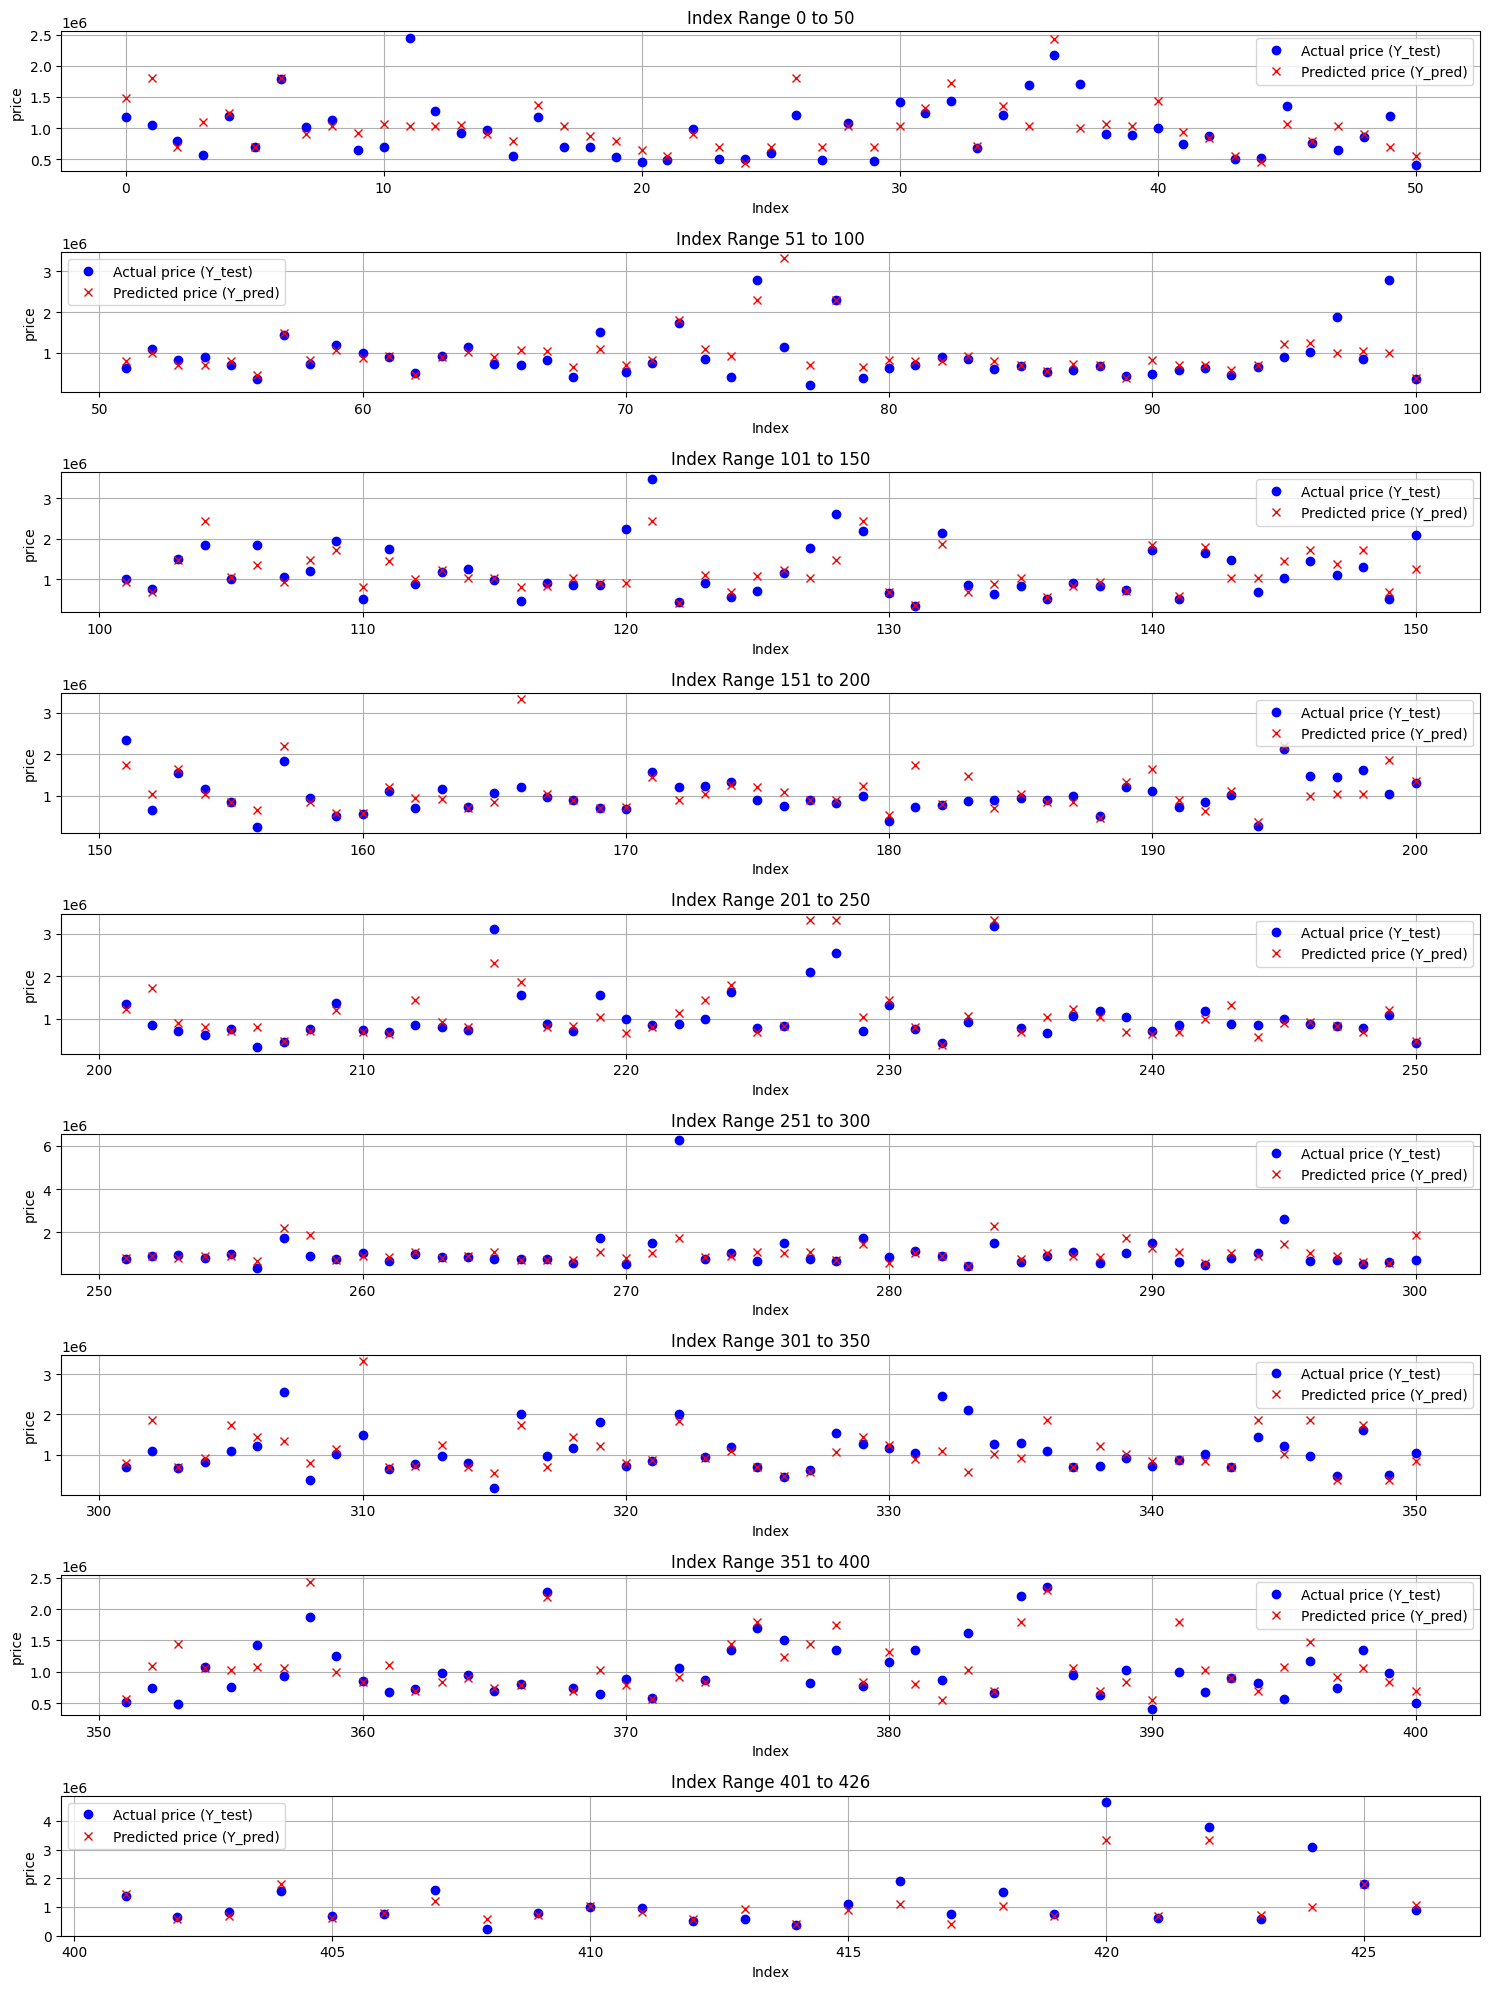

In [ ]:
index = df_test.index
index_ranges = [(0, 50), (51, 100), (101, 150), (151, 200), (201, 250), (251, 300), (301, 350), (351, 400), (401, len(index)-1)]

plt.figure(figsize=(15, 20))

for i, (start, end) in enumerate(index_ranges, start=1):
    plt.subplot(len(index_ranges), 1, i)
    plt.plot(index[start:end+1], y_test[start:end+1], label='Actual price (Y_test)', marker='o', linestyle='', color='blue')
    plt.plot(index[start:end+1], y_pred_test[start:end+1], label='Predicted price (Y_pred)', marker='x', linestyle='', color='red')

    plt.title(f'Index Range {start} to {end}')
    plt.xlabel('Index')
    plt.ylabel('price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

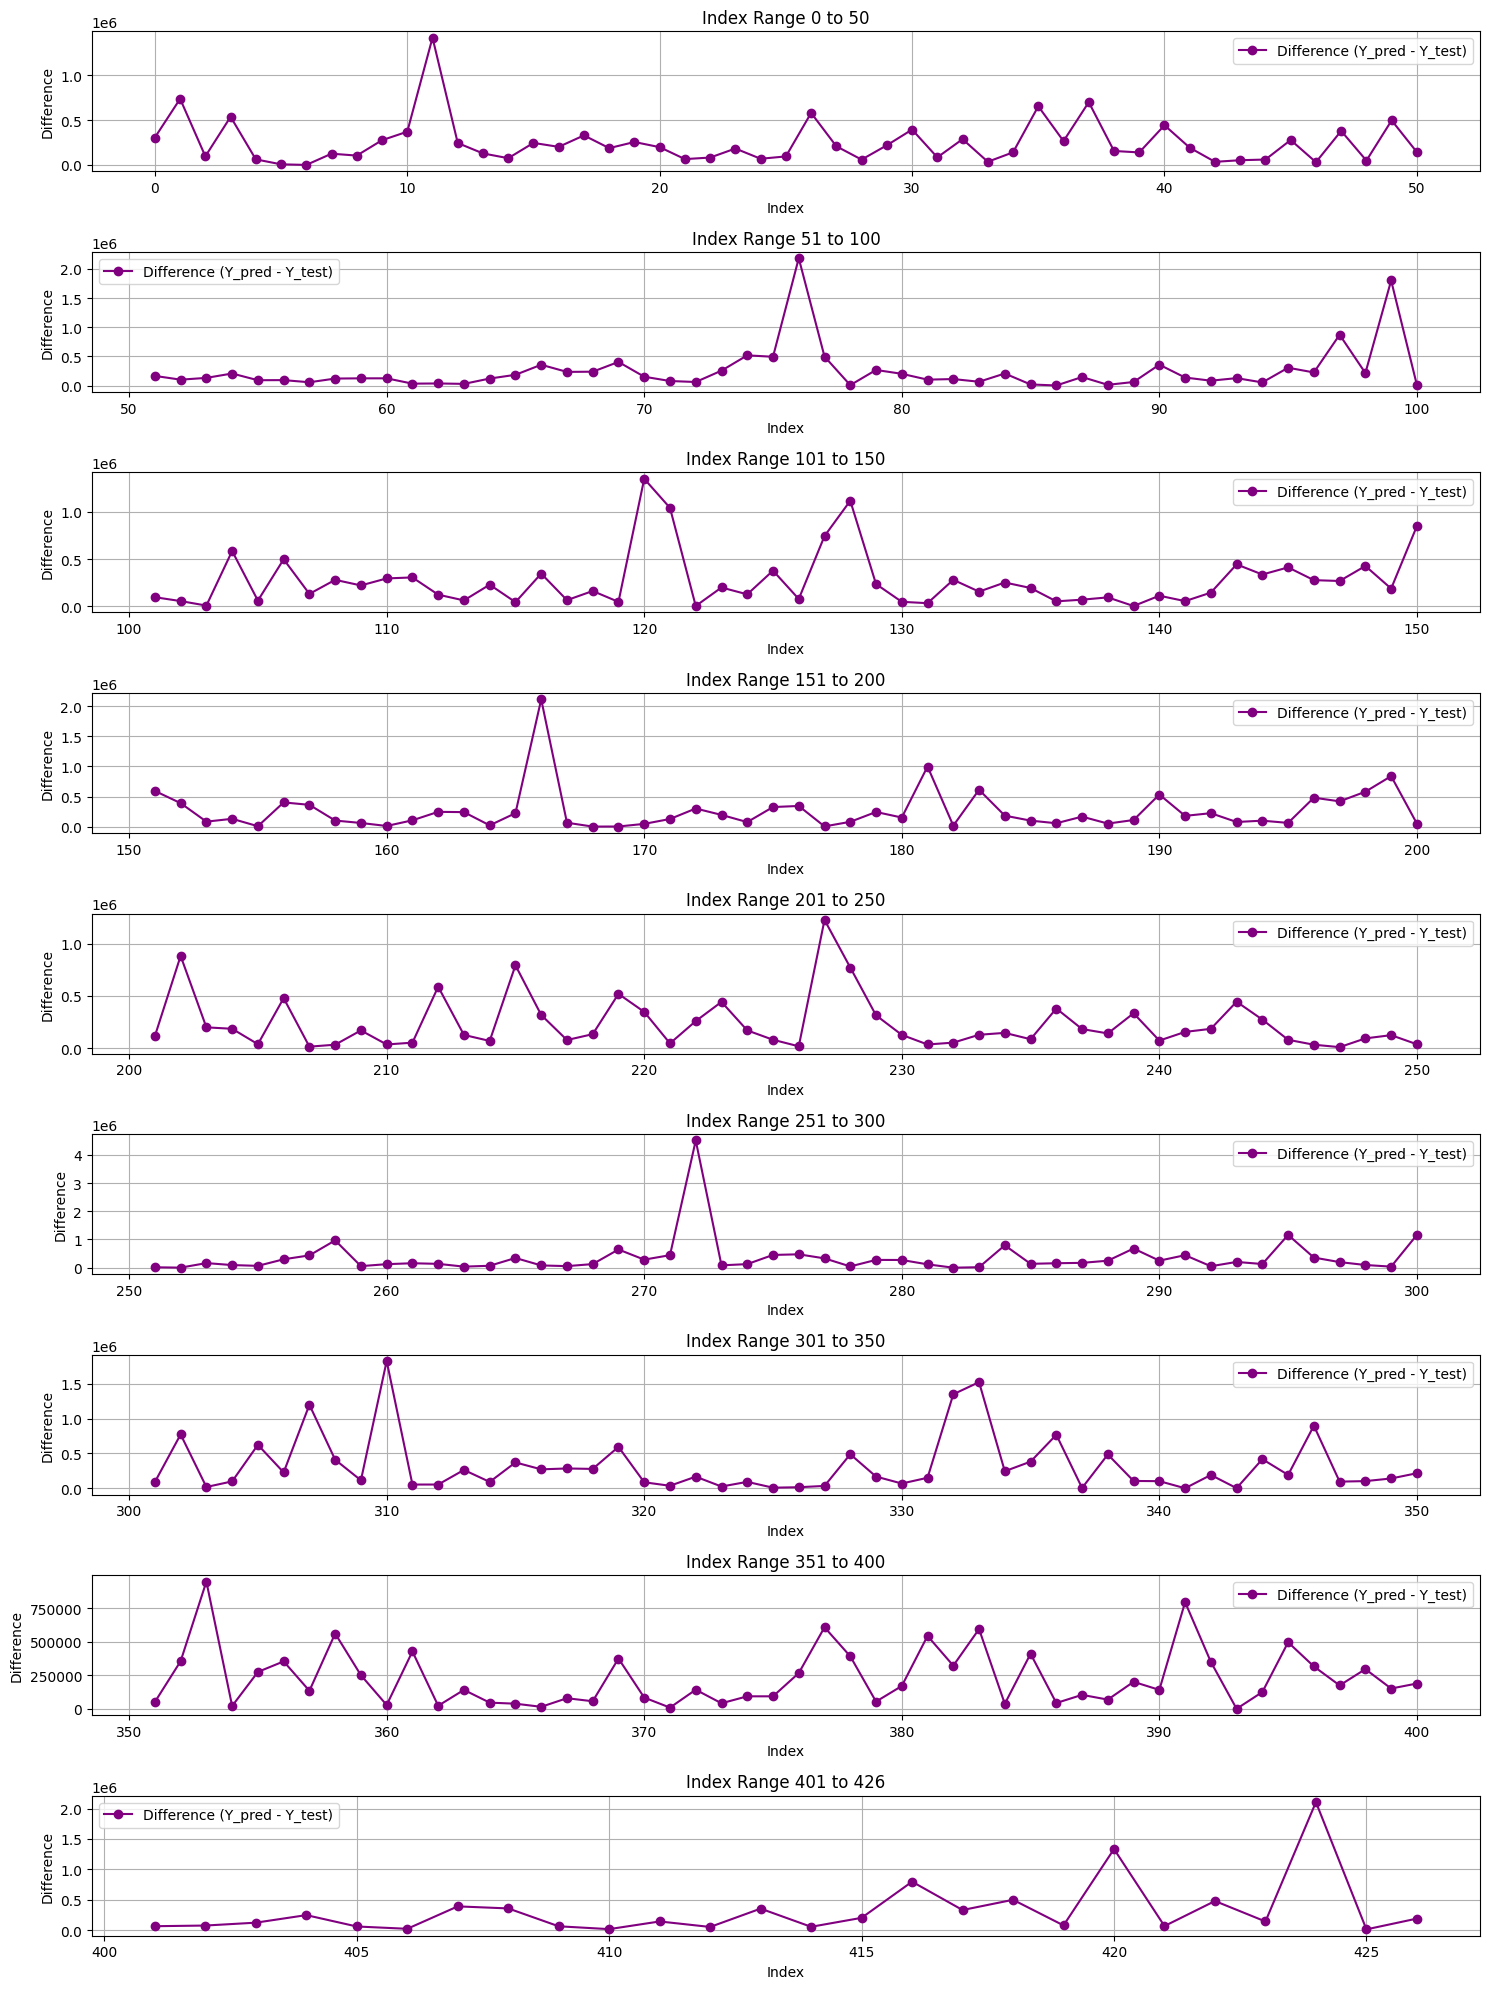

In [ ]:
difference = np.abs(y_pred_test - y_test)
plt.figure(figsize=(15, 20))
for i, (start, end) in enumerate(index_ranges, start=1):
    plt.subplot(len(index_ranges), 1, i)
    plt.plot(index[start:end+1], difference[start:end+1], label='Difference (Y_pred - Y_test)', marker='o', linestyle='-', color='purple')

    plt.title(f'Index Range {start} to {end}')
    plt.xlabel('Index')
    plt.ylabel('Difference')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

Try RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
param_grid_rdf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}


# Initialize the RandomForestRegressor
#rdf = RandomForestRegressor(random_state=42)

# Set up the grid search
#grid_search = GridSearchCV(estimator=rdf, param_grid=param_grid_rdf, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the grid search to the data
#grid_search.fit(X_train, y_train)

# Print the best parameters found
#print("Best parameters:", grid_search.best_params_)

Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [ ]:
param_grid_rdf = {
    'n_estimators': [250, 300, 350, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}


# Initialize the RandomForestRegressor
#rdf = RandomForestRegressor(random_state=42)

# Set up the grid search
#grid_search = GridSearchCV(estimator=rdf, param_grid=param_grid_rdf, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the grid search to the data
#grid_search.fit(X_train, y_train)

#Print the best parameters found
#print("Best parameters:", grid_search.best_params_)

Best parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}


In [ ]:
param_grid_rdf = {
    'n_estimators': [390, 400, 410],
    'max_depth': [20],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}


# Initialize the RandomForestRegressor
#rdf = RandomForestRegressor(random_state=42)

# Set up the grid search
#grid_search = GridSearchCV(estimator=rdf, param_grid=param_grid_rdf, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the grid search to the data
#grid_search.fit(X_train, y_train)

# Print the best parameters found
#print("Best parameters:", grid_search.best_params_)

Best parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}


In [ ]:
rdf = RandomForestRegressor(n_estimators=400, max_depth=20, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', bootstrap=True)
rdf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=400)

In [ ]:
y_pred_rdf = rdf.predict(X_test)
mse = mean_squared_error(y_test, y_pred_rdf)
r2 = r2_score(y_test, y_pred_rdf)

print("MSE of test:", mse)
print("R² score of test:", r2)

MSE of test: 163736640308.94702
R² score of test: 0.5725840714945499


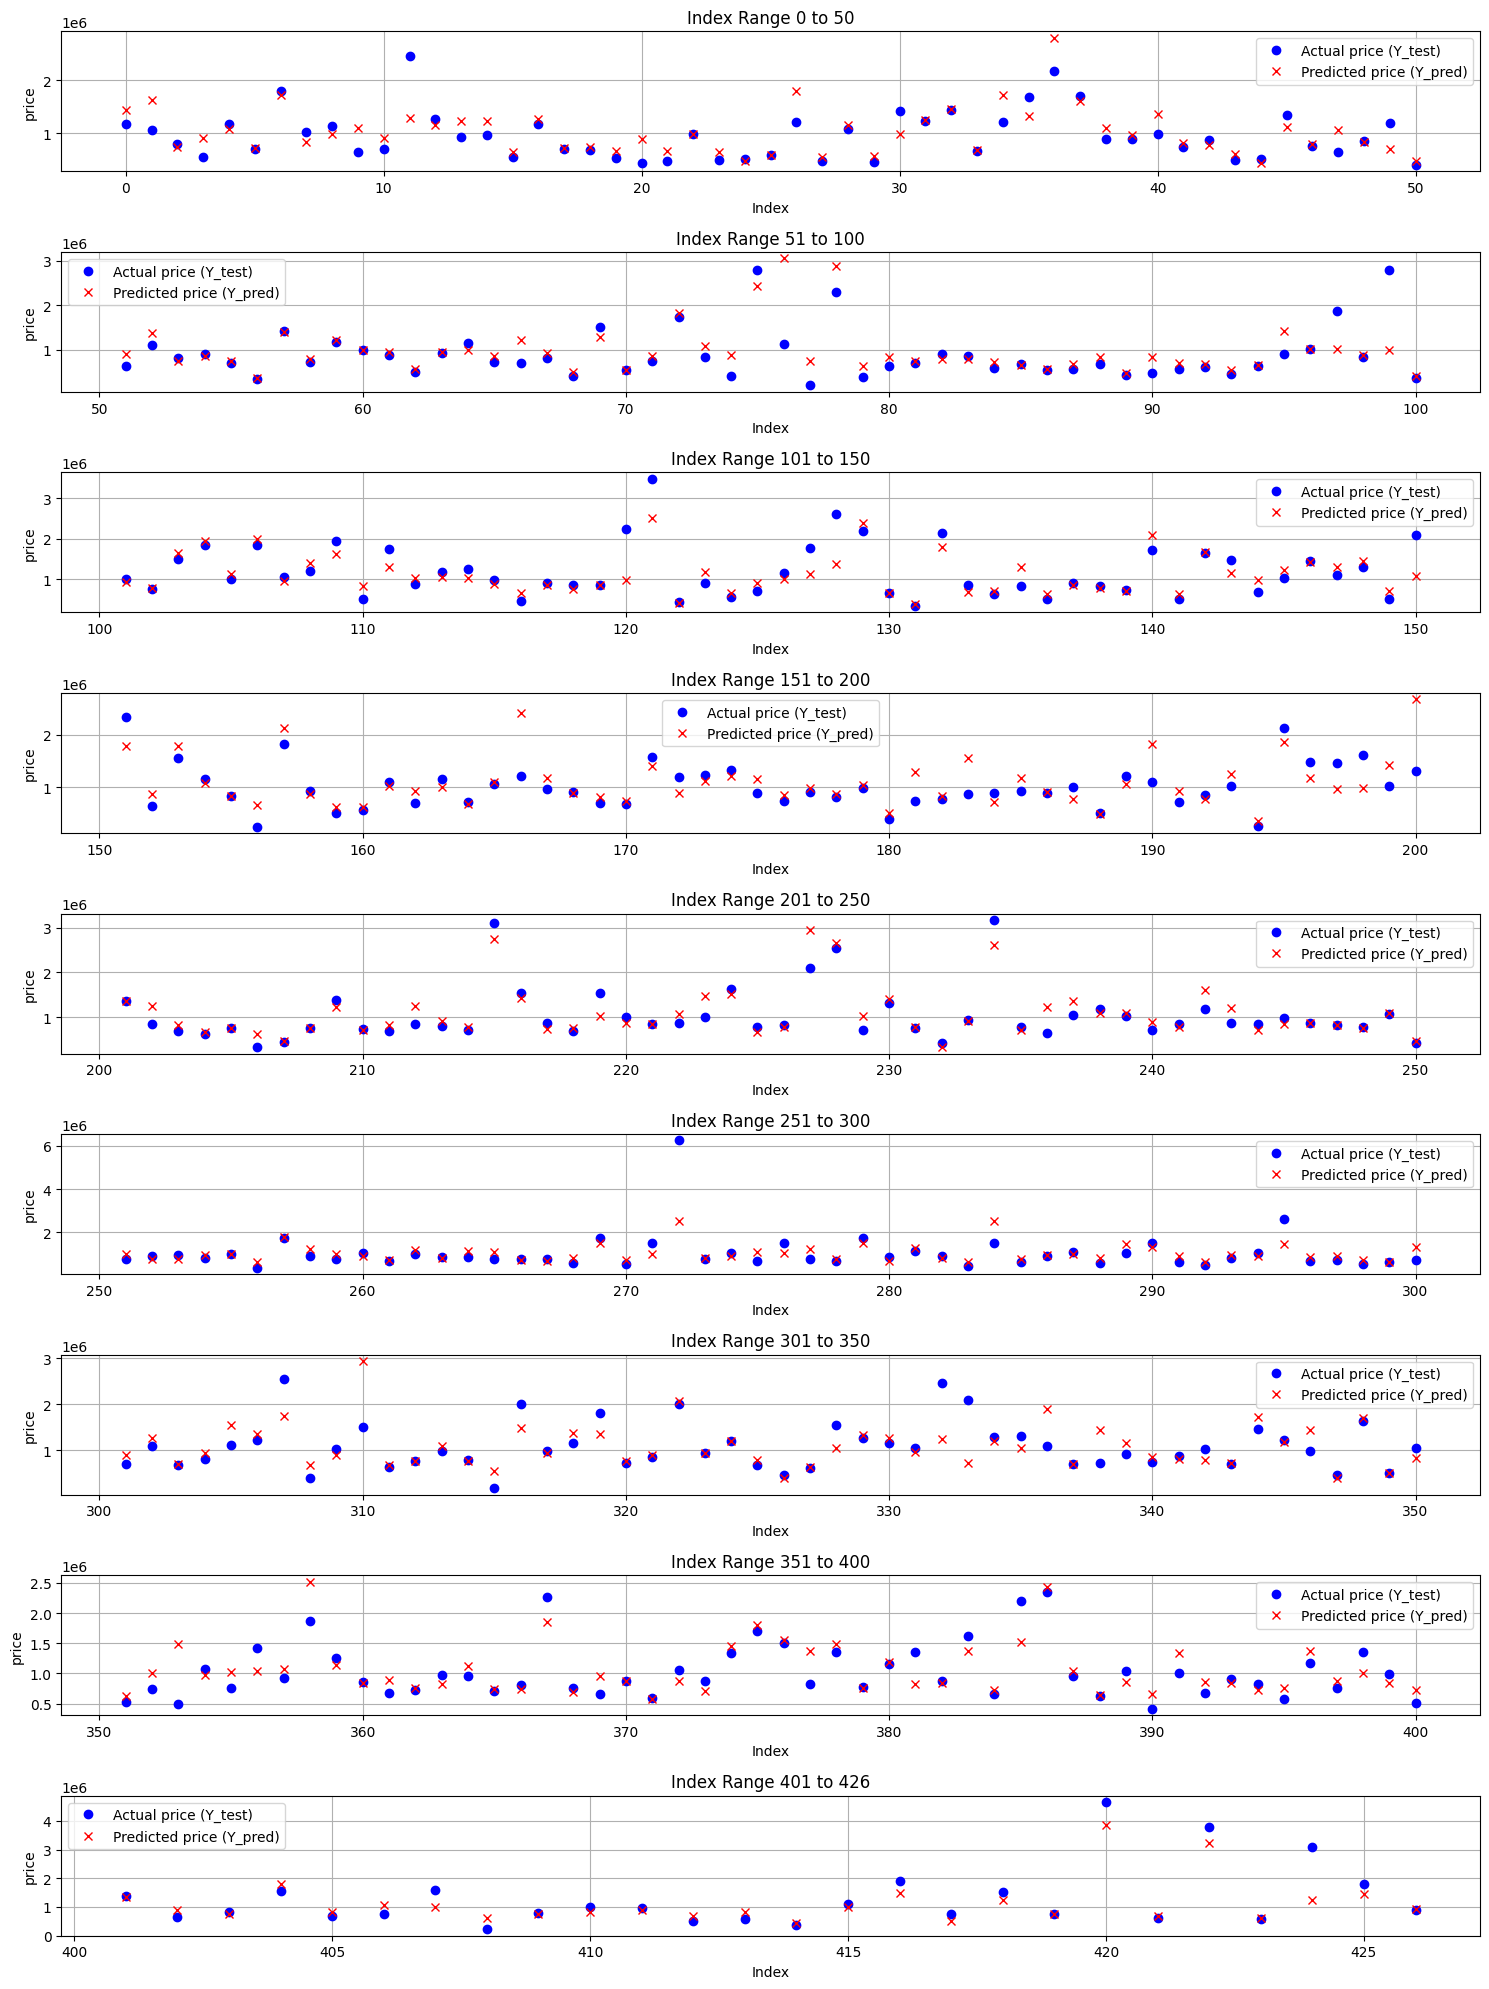

In [ ]:
index = df_test.index
index_ranges = [(0, 50), (51, 100), (101, 150), (151, 200), (201, 250), (251, 300), (301, 350), (351, 400), (401, len(index)-1)]

plt.figure(figsize=(15, 20))

for i, (start, end) in enumerate(index_ranges, start=1):
    plt.subplot(len(index_ranges), 1, i)
    plt.plot(index[start:end+1], y_test[start:end+1], label='Actual price (Y_test)', marker='o', linestyle='', color='blue')
    plt.plot(index[start:end+1], y_pred_rdf[start:end+1], label='Predicted price (Y_pred)', marker='x', linestyle='', color='red')

    plt.title(f'Index Range {start} to {end}')
    plt.xlabel('Index')
    plt.ylabel('price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

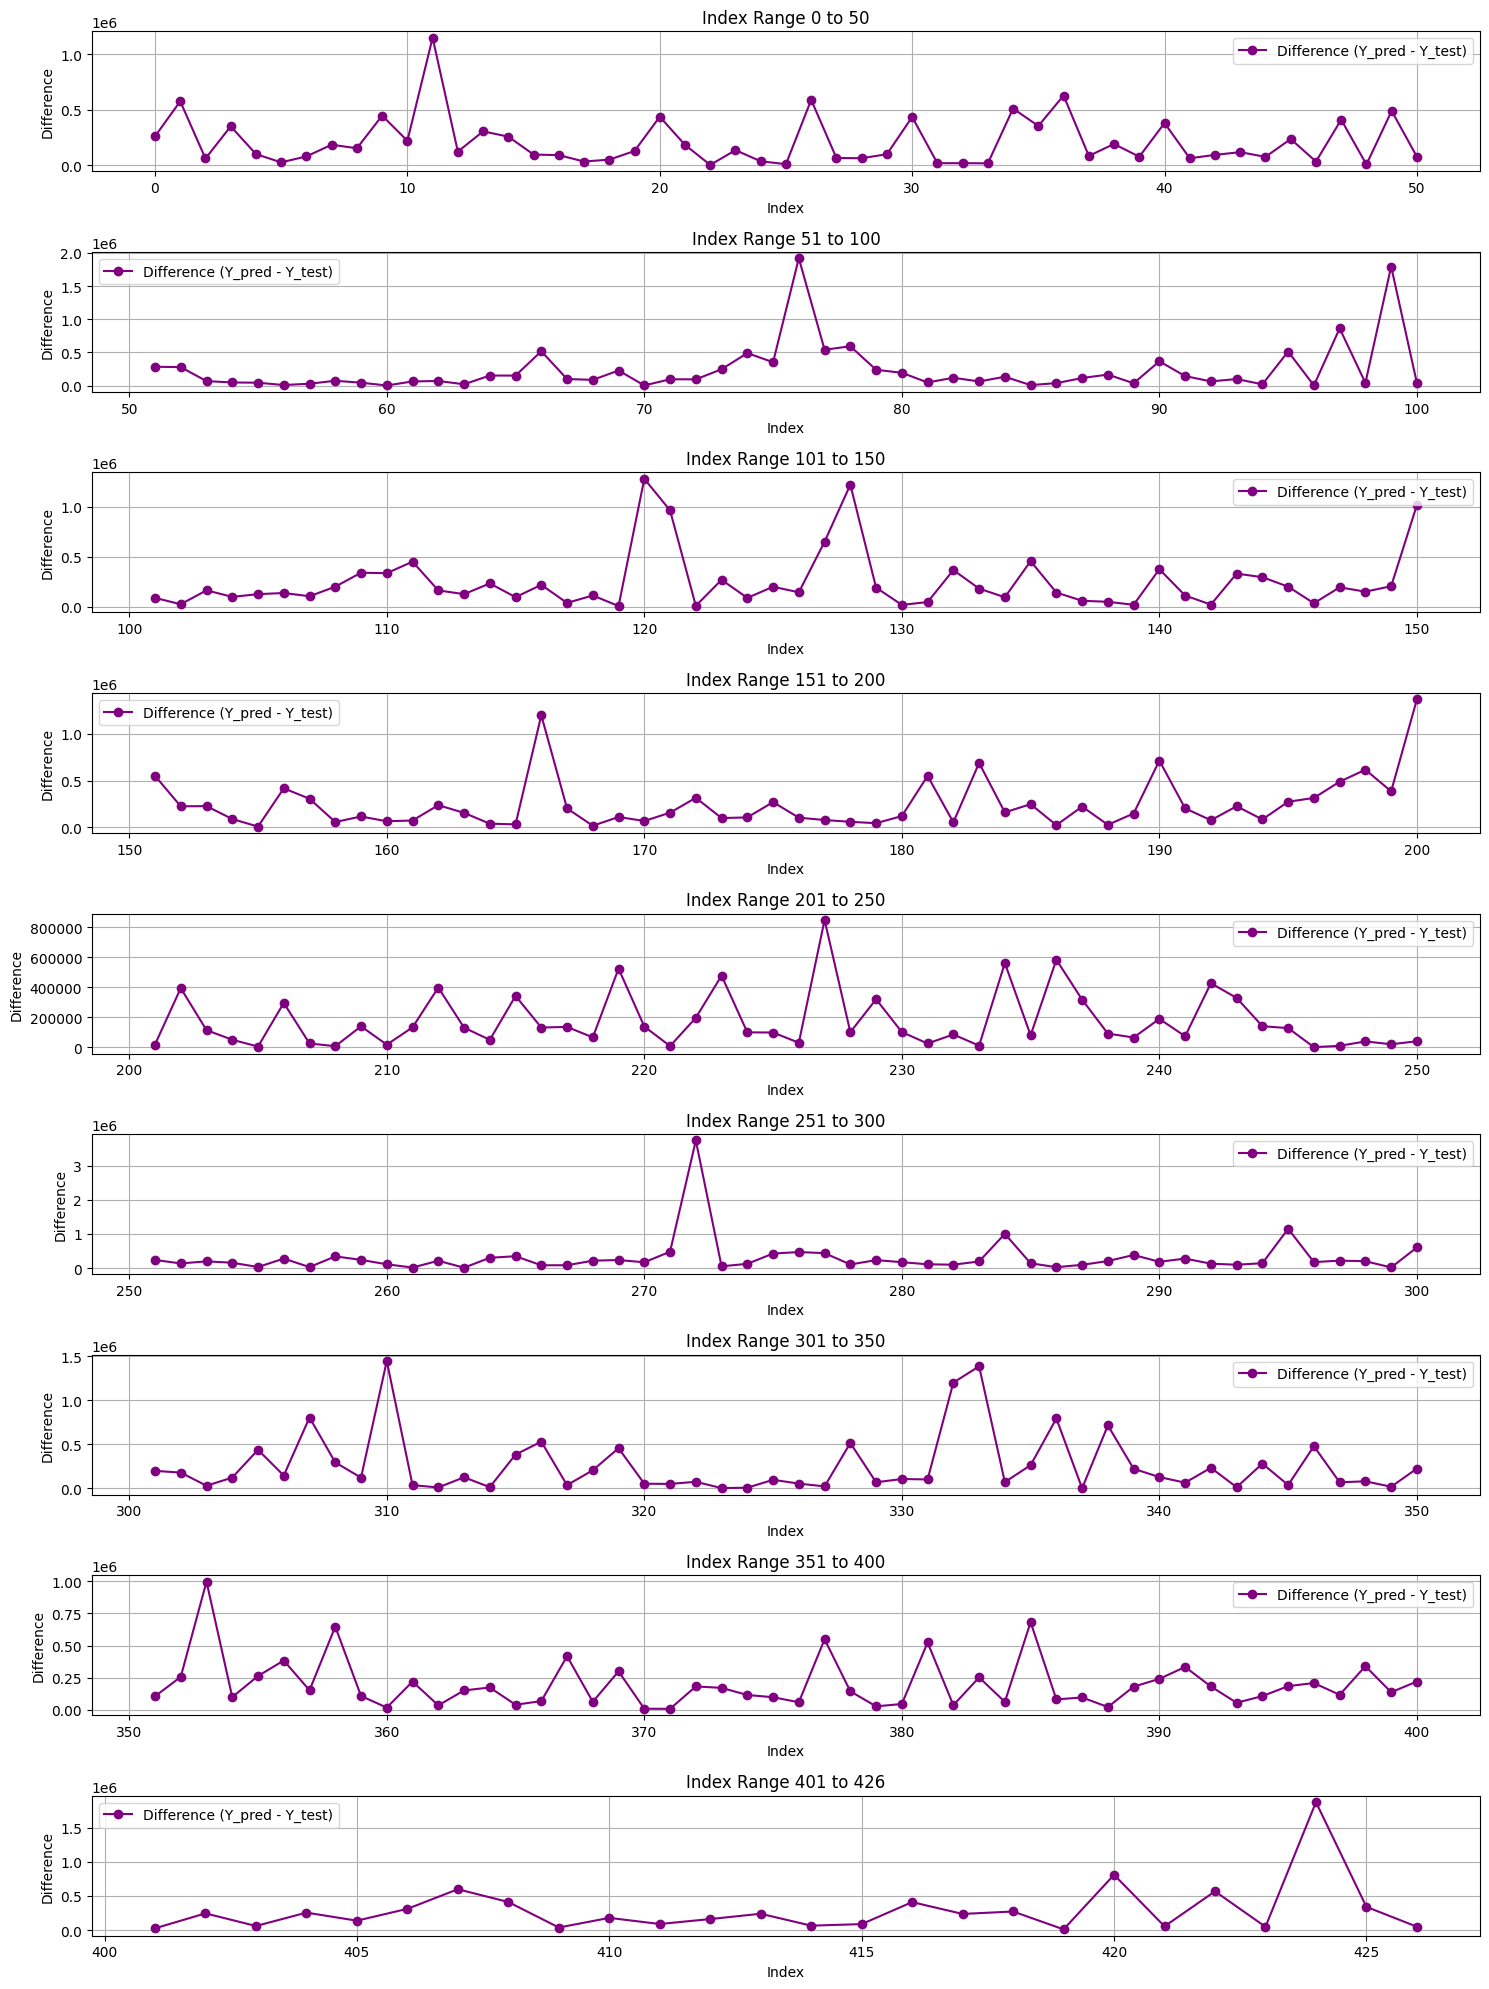

In [ ]:
difference = np.abs(y_pred_rdf - y_test)
plt.figure(figsize=(15, 20))
for i, (start, end) in enumerate(index_ranges, start=1):
    plt.subplot(len(index_ranges), 1, i)
    plt.plot(index[start:end+1], difference[start:end+1], label='Difference (Y_pred - Y_test)', marker='o', linestyle='-', color='purple')

    plt.title(f'Index Range {start} to {end}')
    plt.xlabel('Index')
    plt.ylabel('Difference')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()